In [12]:
import pandas as pd

nifty100_df = pd.read_csv('nifty100.csv')
tickers = [ f'NSE:{n}-EQ' for n in nifty100_df.Symbol.tolist()]

In [13]:
from fyers_helper import prepare_data, load_stock_data
import datetime as dt

data_path = "../data"

end_date = dt.datetime.now()
start_date = dt.datetime(2015, 1, 1)

file_paths = prepare_data(tickers, "1D", start_date=start_date, end_date=end_date, path=data_path, overwrite=False)
loaded_data = load_stock_data(file_paths, data_path, "1D")

Loading 1Dmin data: 100%|██████████| 100/100 [00:00<00:00, 639.04it/s]


In [14]:
ohlc_dict = {
    'Open': 'first',
    'Low': 'min',
    'High': 'max',
    'Close': 'last',
    'exit_time': 'last'
}

df = pd.concat(loaded_data, names=["Stock", "Date"]).reset_index()
# df = df[df.Date >= '2020-01-01'].reset_index(drop=True)
df['exit_time'] = df.Date.shift(-1)
df = df.groupby('Stock').resample('MS', on='Date').agg(ohlc_dict)

In [15]:
df['entry_price'] = df.groupby('Stock')['Open'].shift(-1)
df['exit_price'] = df.groupby('Stock')['Close'].shift(-1)
df['max_low'] = df.groupby('Stock')['Low'].shift(-1)
df['max_high'] = df.groupby('Stock')['High'].shift(-1)
df['returns'] = df.groupby('Stock')['Close'].diff()
df['returns_perc'] = df.groupby('Stock')['Close'].pct_change()
df['next_month_returns'] = df.groupby('Stock')['returns'].shift(-1)
df['next_month_returns_perc'] = df.groupby('Stock')['returns_perc'].shift(-1)

In [16]:
def get_returns(_df, months):
    return _df.groupby('Stock')['Close'].transform(lambda x: x.pct_change(months)).dropna()

returns_12m = get_returns(df, 12)
start_date = returns_12m.index.get_level_values(1)[0]

returns_6m = get_returns(df, 6)
returns_6m = returns_6m[returns_6m.index.get_level_values(1) >= start_date]

returns_3m = get_returns(df, 3)
returns_3m = returns_3m[returns_3m.index.get_level_values(1) >= start_date]

In [17]:
def top_n(_df, n, mask=None):
    dfs = []
    for idx, row in _df.groupby('Date'):
        date_mask = []
        if mask is not None:
            date_mask = mask.loc[idx].index.tolist()
            dfs.append(row.loc[date_mask].nlargest(n))
        else:
            dfs.append(row.nlargest(n))
    return pd.concat(dfs)

top_50 = top_n(returns_12m, 50)
top_30 = top_n(returns_6m, 30, top_50.swaplevel('Stock', 'Date').sort_index())
top_10 = top_n(returns_3m, 10, top_30.swaplevel('Stock', 'Date').sort_index())
top_10 = top_10.swaplevel('Stock', 'Date').sort_index()

In [18]:
from lib import Bank, PositionManager

initial_capital = 500000
leverage = 1


def backtest(pm: PositionManager):
    data = df[df.index.get_level_values(1) >= start_date].dropna(subset=['entry_price', 'exit_price'])
    for idx, group in data.groupby('Date'):
        date = idx
        selected_stocks = top_10.loc[date].index.tolist()
        capital_split = pm.bank.total_capital() / len(selected_stocks)
        for s in selected_stocks:
            d = group.loc[(s, date)]
            capital = d['entry_price'] * round(capital_split/d['entry_price'])
            pm.new_position(s, date, d['entry_price'], capital)
        
        for s in selected_stocks:
            d = group.loc[(s, date)]
            pm.close_position(s, d['exit_time'], d['exit_price'])

if __name__ == "__main__":
    bank = Bank(initial_capital)
    pm = PositionManager(bank, leverage=leverage)
    backtest(pm)

capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not availabl

In [19]:
trades = pm.get_trades()

                       Metric                     Value
0                      Period  2016-01-01 to 2025-08-01
1            Starting capital                 500000.00
2               Final capital                4455094.00
3                Total Trades                     1,096
4                     Winners                       616
5                      Losers                       480
6               Profit factor                      1.68
7       Active Position Count                         0
8   Max holding period (days)                        33
9   Avg holding period (days)                        31
10               Win Rate (%)                     56.20
11               Total Profit              3,955,094.00
12            Total Brokerage                      0.00
13                  Total Tax                  81965.91
14                  Total MTF                       N/A
15                   CAGR (%)                     25.64
16           Max Drawdown (%)                   

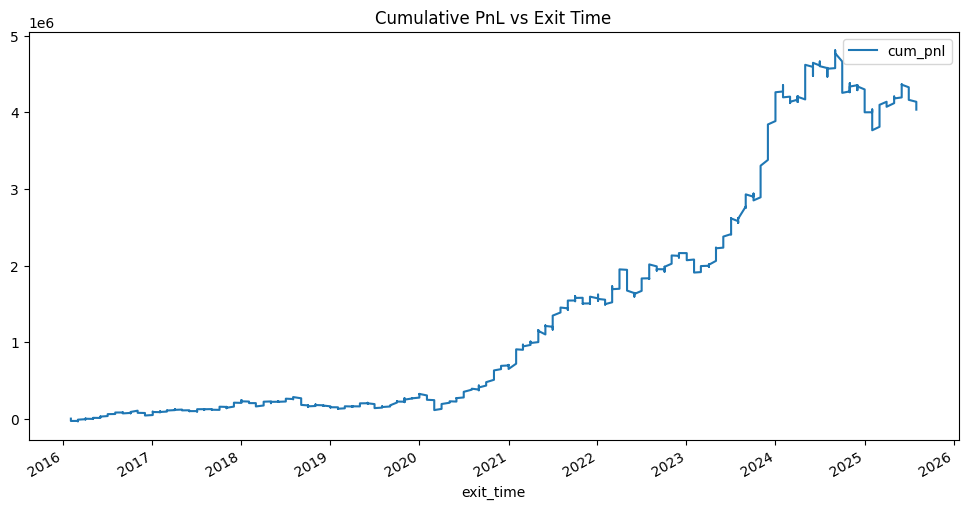

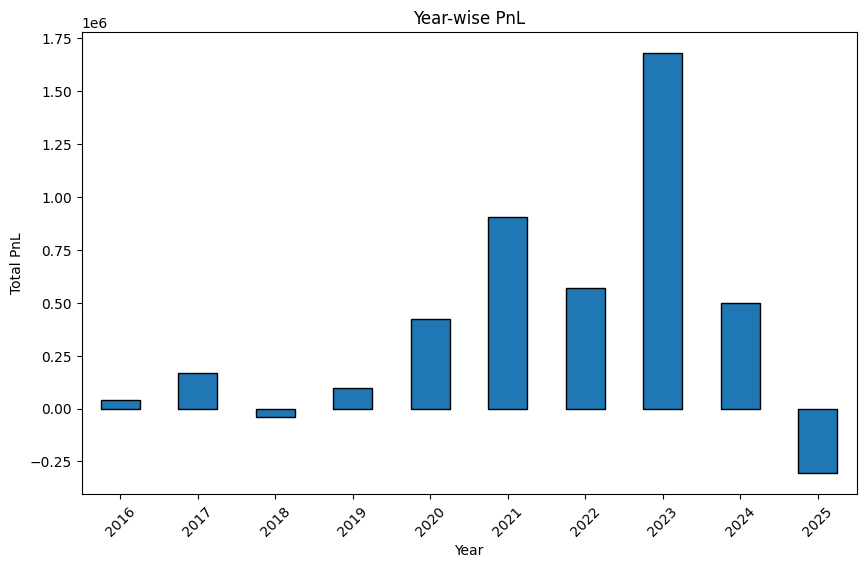

In [20]:
from lib import print_tearsheet, show_equity_curve

print_tearsheet(initial_capital=initial_capital, pm=pm, trades=trades)
show_equity_curve(trades)

In [21]:
trades.to_csv('trades.csv', index=False)

In [22]:
pp = pd.DataFrame(pm.bank.snapshot)
borrow = pp[pp.type == 'borrow'].reset_index(drop=True)
settle = pp[pp.type == 'settle'].reset_index(drop=True)
pd.concat([borrow, settle], axis=1).to_csv('snapshot.csv', index=False)